# Predictive distribution for Bayesian Linear Regression

The predictive distribution takes the form
$$
    p(t | x, {\bf t}, \alpha, \beta) = \mathcal{N}\left(t| {\bf m}_N^T \phi({\bf x}), \frac{1}{\beta} + \phi({\bf x})^T{\bf S}_N\phi({\bf x})\right)
$$

We consider a Gaussian basis function of the form:
$$
    \phi_j(x) = \exp\left(-\frac{(x - \mu_j)^2}{2s^2}\right) 
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from patsy import dmatrix
import branca

In [10]:
%config InlineBackend.figure_format = "retina"

Basis functions of choice

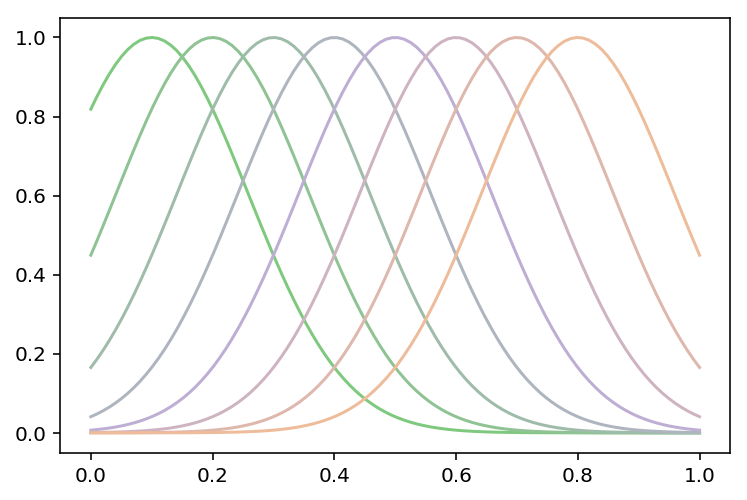

In [196]:
def gaussian_bf(x, mu, s): return np.exp(-(x - mu) ** 2 / s)

colors = branca.colormap.linear.Accent_03
s = 0.05
mu = np.arange(0.1, 0.9, 0.1)
for j, mu_j in enumerate(mu):
    plt.plot(x_true, gaussian_bf(x_true, mu_j, s), c=colors(j / len(mu)))

In [16]:
def y(x): return np.sin(2 * np.pi * x)

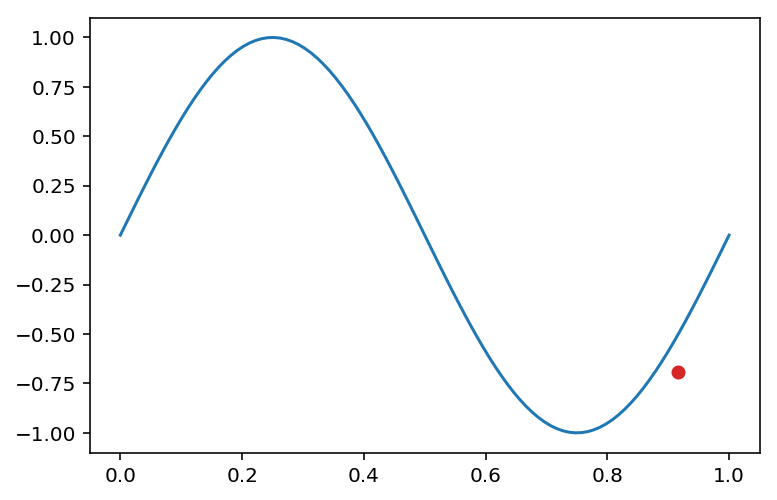

In [53]:
x_true = np.linspace(0, 1, 100)
y_true = y(x_true)

def sample_sinusoidal(S, beta):
    x_samp = np.random.uniform(0, 1, S) 
    y_samp = y(x_samp) + np.random.randn(S) / beta
    return x_samp, y_samp

np.random.seed(314)
precision = 8
x_s1, y_s1 = sample_sinusoidal(1, precision)
x_s2, y_s2 = sample_sinusoidal(2, precision)
x_s4, y_s4 = sample_sinusoidal(4, precision)
x_s25, y_s25 = sample_sinusoidal(25, precision)

plt.plot(x_true, y_true)
plt.scatter(x_s1, y_s1, c="tab:red")

In [235]:
from numpy.linalg import inv

In [244]:
alpha = 0.2
SN = inv(alpha + beta * Phi.T @ Phi)
mN = SN @ Phi.T @ y_s25.reshape(-1, 1)


(3, 1)

In [234]:
s = 0.1
mu = [0, 0.5, 1]
Phi = np.column_stack((gaussian_bf(x_s25, mu_j, s) for mu_j in mu))